# Markov decision processes (MDPs)

This IPy notebook acts as supporting material for topics covered in **Chapter 17 Making Complex Decisions** of the book* Artificial Intelligence: A Modern Approach*. We makes use of the implementations in mdp.py module. This notebook also includes a brief summary of the main topics as a review. Let us import everything from the mdp module to get started.

In [1]:
from mdp import *
from notebook import psource, pseudocode

## CONTENTS

* Overview
* MDP
* Grid MDP
* Value Iteration
    * Value Iteration Visualization
* Policy Iteration

## OVERVIEW

Before we start playing with the actual implementations let us review a couple of things about MDPs.

- A stochastic process has the **Markov property** if the conditional probability distribution of future states of the process (conditional on both past and present states) depends only upon the present state, not on the sequence of events that preceded it.

    -- Source: [Wikipedia](https://en.wikipedia.org/wiki/Markov_property)

Often it is possible to model many different phenomena as a Markov process by being flexible with our definition of state.
   

- MDPs help us deal with fully-observable and non-deterministic/stochastic environments. For dealing with partially-observable and stochastic cases we make use of generalization of MDPs named POMDPs (partially observable Markov decision process).

Our overall goal to solve a MDP is to come up with a policy which guides us to select the best action in each state so as to maximize the expected sum of future rewards.

## MDP

To begin with let us look at the implementation of MDP class defined in mdp.py The docstring tells us what all is required to define a MDP namely - set of states, actions, initial state, transition model, and a reward function. Each of these are implemented as methods. Do not close the popup so that you can follow along the description of code below.

In [2]:
psource(MDP)

The **_ _init_ _** method takes in the following parameters:

- init: the initial state.
- actlist: List of actions possible in each state.
- terminals: List of terminal states where only possible action is exit
- gamma: Discounting factor. This makes sure that delayed rewards have less value compared to immediate ones.

**R** method returns the reward for each state by using the self.reward dict.

**T** method is not implemented and is somewhat different from the text. Here we return (probability, s') pairs where s' belongs to list of possible state by taking action a in state s.

**actions** method returns list of actions possible in each state. By default it returns all actions for states other than terminal states.


Now let us implement the simple MDP in the image below. States A, B have actions X, Y available in them. Their probabilities are shown just above the arrows. We start with using MDP as base class for our CustomMDP. Obviously we need to make a few changes to suit our case. We make use of a transition matrix as our transitions are not very simple.
<img src="files/images/mdp-a.png">

In [3]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
t = {
    "A": {
            "X": [(0.3, "A"), (0.7, "B")],
            "Y": [(1.0, "A")]
         },
    "B": {
            "X": {(0.8, "End"), (0.2, "B")},
            "Y": {(1.0, "A")}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

In [4]:
class CustomMDP(MDP):
    def __init__(self, init, terminals, transition_matrix, reward = None, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        MDP.__init__(self, init, actlist, terminals, transition_matrix, reward, gamma=gamma)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else: 
            return self.t[state][action]

Finally we instantize the class with the parameters for our MDP in the picture.

In [5]:
our_mdp = CustomMDP(init, terminals, t, rewards, gamma=.9)

With this we have successfully represented our MDP. Later we will look at ways to solve this MDP.

## GRID MDP

Now we look at a concrete implementation that makes use of the MDP as base class. The GridMDP class in the mdp module is used to represent a grid world MDP like the one shown in  in **Fig 17.1** of the AIMA Book. We assume for now that the environment is _fully observable_, so that the agent always knows where it is. The code should be easy to understand if you have gone through the CustomMDP example.

In [6]:
psource(GridMDP)

The **_ _init_ _** method takes **grid** as an extra parameter compared to the MDP class. The grid is a nested list of rewards in states.

**go** method returns the state by going in particular direction by using vector_add.

**T** method is not implemented and is somewhat different from the text. Here we return (probability, s') pairs where s' belongs to list of possible state by taking action a in state s.

**actions** method returns list of actions possible in each state. By default it returns all actions for states other than terminal states.

**to_arrows** are used for representing the policy in a grid like format.

We can create a GridMDP like the one in **Fig 17.1** as follows: 

    GridMDP([[-0.04, -0.04, -0.04, +1],
            [-0.04, None,  -0.04, -1],
            [-0.04, -0.04, -0.04, -0.04]],
            terminals=[(3, 2), (3, 1)])
            
In fact the **sequential_decision_environment** in mdp module has been instantized using the exact same code.

In [7]:
sequential_decision_environment

# VALUE ITERATION

Now that we have looked how to represent MDPs. Let's aim at solving them. Our ultimate goal is to obtain an optimal policy. We start with looking at Value Iteration and a visualisation that should help us understanding it better.

We start by calculating Value/Utility for each of the states. The Value of each state is the expected sum of discounted future rewards given we start in that state and follow a particular policy $\pi$. The value or the utility of a state is given by

$$U(s)=R(s)+\gamma\max_{a\epsilon A(s)}\sum_{s'} P(s'\ |\ s,a)U(s')$$

This is called the Bellman equation. The algorithm Value Iteration (**Fig. 17.4** in the book) relies on finding solutions of this Equation. The intuition Value Iteration works is because values propagate through the state space by means of local updates. This point will we more clear after we encounter the visualisation. For more information you can refer to **Section 17.2** of the book. 


In [8]:
psource(value_iteration)

It takes as inputs two parameters, an MDP to solve and epsilon, the maximum error allowed in the utility of any state. It returns a dictionary containing utilities where the keys are the states and values represent utilities. <br> Value Iteration starts with arbitrary initial values for the utilities, calculates the right side of the Bellman equation and plugs it into the left hand side, thereby updating the utility of each state from the utilities of its neighbors. 
This is repeated until equilibrium is reached. 
It works on the principle of _Dynamic Programming_ - using precomputed information to simplify the subsequent computation. 
If $U_i(s)$ is the utility value for state $s$ at the $i$ th iteration, the iteration step, called Bellman update, looks like this:

$$ U_{i+1}(s) \leftarrow R(s) + \gamma \max_{a \epsilon A(s)} \sum_{s'} P(s'\ |\ s,a)U_{i}(s') $$

As you might have noticed, `value_iteration` has an infinite loop. How do we decide when to stop iterating? 
The concept of _contraction_ successfully explains the convergence of value iteration. 
Refer to **Section 17.2.3** of the book for a detailed explanation. 
In the algorithm, we calculate a value $delta$ that measures the difference in the utilities of the current time step and the previous time step. 

$$\delta = \max{(\delta, \begin{vmatrix}U_{i + 1}(s) - U_i(s)\end{vmatrix})}$$

This value of delta decreases as the values of $U_i$ converge.
We terminate the algorithm if the $\delta$ value is less than a threshold value determined by the hyperparameter _epsilon_.

$$\delta \lt \epsilon \frac{(1 - \gamma)}{\gamma}$$

To summarize, the Bellman update is a _contraction_ by a factor of $gamma$ on the space of utility vectors. 
Hence, from the properties of contractions in general, it follows that `value_iteration` always converges to a unique solution of the Bellman equations whenever $gamma$ is less than 1.
We then terminate the algorithm when a reasonable approximation is achieved.
In practice, it often occurs that the policy $pi$ becomes optimal long before the utility function converges. For the given 4 x 3 environment with $gamma = 0.9$, the policy $pi$ is optimal when $i = 4$ (at the 4th iteration), even though the maximum error in the utility function is stil 0.46. This can be clarified from **figure 17.6** in the book. Hence, to increase computational efficiency, we often use another method to solve MDPs called Policy Iteration which we will see in the later part of this notebook. 
<br>For now, let us solve the **sequential_decision_environment** GridMDP using `value_iteration`.

In [9]:
value_iteration(sequential_decision_environment)

{(0, 0): 0.2962883154554812,
 (0, 1): 0.3984432178350045,
 (0, 2): 0.5093943765842497,
 (1, 0): 0.25386699846479516,
 (1, 2): 0.649585681261095,
 (2, 0): 0.3447542300124158,
 (2, 1): 0.48644001739269643,
 (2, 2): 0.7953620878466678,
 (3, 0): 0.12987274656746342,
 (3, 1): -1.0,
 (3, 2): 1.0}

The pseudocode for the algorithm:

In [10]:
pseudocode("Value-Iteration")

### AIMA3e
__function__ VALUE-ITERATION(_mdp_, _&epsi;_) __returns__ a utility function  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_),  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;rewards _R_(_s_), discount _&gamma;_  
&emsp;&emsp;&emsp;_&epsi;_, the maximum error allowed in the utility of any state  
&emsp;__local variables__: _U_, _U&prime;_, vectors of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&delta;_, the maximum change in the utility of any state in an iteration  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; _U&prime;_; _&delta;_ &larr; 0  
&emsp;&emsp;&emsp;__for each__ state _s_ in _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;_U&prime;_\[_s_\] &larr; _R_(_s_) &plus; _&gamma;_ max<sub>_a_ &isin; _A_(_s_)</sub> &Sigma; _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\]  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert; &gt; _&delta;_ __then__ _&delta;_ &larr; &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert;  
&emsp;__until__ _&delta;_ &lt; _&epsi;_(1 &minus; _&gamma;_)&sol;_&gamma;_  
&emsp;__return__ _U_  

---
__Figure ??__ The value iteration algorithm for calculating utilities of states. The termination condition is from Equation (__??__).

### AIMA3e
__function__ VALUE-ITERATION(_mdp_, _&epsi;_) __returns__ a utility function  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_),  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;rewards _R_(_s_), discount _&gamma;_  
&emsp;&emsp;&emsp;_&epsi;_, the maximum error allowed in the utility of any state  
&emsp;__local variables__: _U_, _U&prime;_, vectors of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&delta;_, the maximum change in the utility of any state in an iteration  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; _U&prime;_; _&delta;_ &larr; 0  
&emsp;&emsp;&emsp;__for each__ state _s_ in _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;_U&prime;_\[_s_\] &larr; _R_(_s_) &plus; _&gamma;_ max<sub>_a_ &isin; _A_(_s_)</sub> &Sigma; _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\]  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert; &gt; _&delta;_ __then__ _&delta;_ &larr; &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert;  
&emsp;__until__ _&delta;_ &lt; _&epsi;_(1 &minus; _&gamma;_)&sol;_&gamma;_  
&emsp;__return__ _U_  

---
__Figure ??__ The value iteration algorithm for calculating utilities of states. The termination condition is from Equation (__??__).

## VALUE ITERATION VISUALIZATION

To illustrate that values propagate out of states let us create a simple visualisation. We will be using a modified version of the value_iteration function which will store U over time. We will also remove the parameter epsilon and instead add the number of iterations we want.

In [11]:
def value_iteration_instru(mdp, iterations=20):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

Next, we define a function to create the visualisation from the utilities returned by **value_iteration_instru**. The reader need not concern himself with the code that immediately follows as it is the usage of Matplotib with IPython Widgets. If you are interested in reading more about these visit [ipywidgets.readthedocs.io](http://ipywidgets.readthedocs.io)

In [12]:
columns = 4
rows = 3
U_over_time = value_iteration_instru(sequential_decision_environment)

In [13]:
%matplotlib inline
from notebook import make_plot_grid_step_function

plot_grid_step = make_plot_grid_step_function(columns, rows, U_over_time)

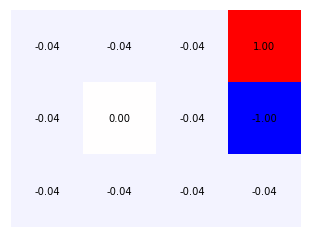

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


In [14]:
import ipywidgets as widgets
from IPython.display import display
from notebook import make_visualize

iteration_slider = widgets.IntSlider(min=1, max=15, step=1, value=0)
w=widgets.interactive(plot_grid_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])
a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

Move the slider above to observe how the utility changes across iterations. It is also possible to move the slider using arrow keys or to jump to the value by directly editing the number with a double click. The **Visualize Button** will automatically animate the slider for you. The **Extra Delay Box** allows you to set time delay in seconds upto one second for each time step. There is also an interactive editor for grid-world problems `grid_mdp.py` in the gui folder for you to play around with.

# POLICY ITERATION

We have already seen that value iteration converges to the optimal policy long before it accurately estimates the utility function. 
If one action is clearly better than all the others, then the exact magnitude of the utilities in the states  involved need not be precise. 
The policy iteration algorithm works on this insight. 
The algorithm executes two fundamental steps:
* **Policy evaluation**: Given a policy _&#960;&#7522;_, calculate _U&#7522; = U(&#960;&#7522;)_, the utility of each state if _&#960;&#7522;_ were to be executed.
* **Policy improvement**: Calculate a new policy _&#960;&#7522;&#8330;&#8321;_ using one-step look-ahead based on the utility values calculated.

The algorithm terminates when the policy improvement step yields no change in the utilities. 
Refer to **Figure 17.6** in the book to see how this is an improvement over value iteration.
We now have a simplified version of the Bellman equation

$$U_i(s) = R(s) + \gamma \sum_{s'}P(s'\ |\ s, \pi_i(s))U_i(s')$$

An important observation in this equation is that this equation doesn't have the `max` operator, which makes it linear.
For _n_ states, we have _n_ linear equations with _n_ unknowns, which can be solved exactly in time _**O(n&#179;)**_.
For more implementational details, have a look at **Section 17.3**.
Let us now look at how the expected utility is found and how `policy_iteration` is implemented.

In [15]:
psource(expected_utility)

In [16]:
psource(policy_iteration)

<br>Fortunately, it is not necessary to do _exact_ policy evaluation. 
The utilities can instead be reasonably approximated by performing some number of simplified value iteration steps.
The simplified Bellman update equation for the process is

$$U_{i+1}(s) \leftarrow R(s) + \gamma\sum_{s'}P(s'\ |\ s,\pi_i(s))U_{i}(s')$$

and this is repeated _k_ times to produce the next utility estimate. This is called _modified policy iteration_.

In [17]:
psource(policy_evaluation)

Let us now solve **`sequential_decision_environment`** using `policy_iteration`.

In [18]:
policy_iteration(sequential_decision_environment)

{(0, 0): (0, 1),
 (0, 1): (0, 1),
 (0, 2): (1, 0),
 (1, 0): (1, 0),
 (1, 2): (1, 0),
 (2, 0): (0, 1),
 (2, 1): (0, 1),
 (2, 2): (1, 0),
 (3, 0): (-1, 0),
 (3, 1): None,
 (3, 2): None}

In [19]:
pseudocode('Policy-Iteration')

### AIMA3e
__function__ POLICY-ITERATION(_mdp_) __returns__ a policy  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_)  
&emsp;__local variables__: _U_, a vector of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&pi;_, a policy vector indexed by state, initially random  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; POLICY\-EVALUATION(_&pi;_, _U_, _mdp_)  
&emsp;&emsp;&emsp;_unchanged?_ &larr; true  
&emsp;&emsp;&emsp;__for each__ state _s_ __in__ _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ max<sub>_a_ &isin; _A_(_s_)</sub> &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\] &gt; &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _&pi;_\[_s_\]) _U_\[_s&prime;_\] __then do__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&pi;_\[_s_\] &larr; argmax<sub>_a_ &isin; _A_(_s_)</sub> &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\]  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_unchanged?_ &larr; false  
&emsp;__until__ _unchanged?_  
&emsp;__return__ _&pi;_  

---
__Figure ??__ The policy iteration algorithm for calculating an optimal policy.

### AIMA3e
__function__ POLICY-ITERATION(_mdp_) __returns__ a policy  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_)  
&emsp;__local variables__: _U_, a vector of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&pi;_, a policy vector indexed by state, initially random  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; POLICY\-EVALUATION(_&pi;_, _U_, _mdp_)  
&emsp;&emsp;&emsp;_unchanged?_ &larr; true  
&emsp;&emsp;&emsp;__for each__ state _s_ __in__ _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ max<sub>_a_ &isin; _A_(_s_)</sub> &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\] &gt; &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _&pi;_\[_s_\]) _U_\[_s&prime;_\] __then do__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&pi;_\[_s_\] &larr; argmax<sub>_a_ &isin; _A_(_s_)</sub> &Sigma;<sub>_s&prime;_</sub> _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\]  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_unchanged?_ &larr; false  
&emsp;__until__ _unchanged?_  
&emsp;__return__ _&pi;_  

---
__Figure ??__ The policy iteration algorithm for calculating an optimal policy.

## Sequential Decision Problems

Now that we have the tools required to solve MDPs, let us see how Sequential Decision Problems can be solved step by step and how a few built-in tools in the GridMDP class help us better analyse the problem at hand. 
As always, we will work with the grid world from **Figure 17.1** from the book.
![title](images/grid_mdp.jpg)
<br>This is the environment for our agent.
We assume for now that the environment is _fully observable_, so that the agent always knows where it is.
We also assume that the transitions are **Markovian**, that is, the probability of reaching state $s'$ from state $s$ depends only on $s$ and not on the history of earlier states.
Almost all stochastic decision problems can be reframed as a Markov Decision Process just by tweaking the definition of a _state_ for that particular problem.
<br>
However, the actions of our agent in this environment are unreliable. In other words, the motion of our agent is stochastic. 
<br><br>
More specifically, the agent may - 
* move correctly in the intended direction with a probability of _0.8_,  
* move $90^\circ$ to the right of the intended direction with a probability 0.1
* move $90^\circ$ to the left of the intended direction with a probability 0.1
<br><br>
The agent stays put if it bumps into a wall.
![title](images/grid_mdp_agent.jpg)

These properties of the agent are called the transition properties and are hardcoded into the GridMDP class as you can see below.

In [20]:
psource(GridMDP.T)

To completely define our task environment, we need to specify the utility function for the agent. 
This is the function that gives the agent a rough estimate of how good being in a particular state is, or how much _reward_ an agent receives by being in that state.
The agent then tries to maximize the reward it gets.
As the decision problem is sequential, the utility function will depend on a sequence of states rather than on a single state.
For now, we simply stipulate that in each state $s$, the agent receives a finite reward $R(s)$.

For any given state, the actions the agent can take are encoded as given below:
- Move Up: (0, 1)
- Move Down: (0, -1)
- Move Left: (-1, 0)
- Move Right: (1, 0)
- Do nothing: `None`

We now wonder what a valid solution to the problem might look like. 
We cannot have fixed action sequences as the environment is stochastic and we can eventually end up in an undesirable state.
Therefore, a solution must specify what the agent shoulddo for _any_ state the agent might reach.
<br>
Such a solution is known as a **policy** and is usually denoted by $\pi$.
<br>
The **optimal policy** is the policy that yields the highest expected utility an is usually denoted by $\pi^*$.
<br>
The `GridMDP` class has a useful method `to_arrows` that outputs a grid showing the direction the agent should move, given a policy.
We will use this later to better understand the properties of the environment.

In [21]:
psource(GridMDP.to_arrows)

This method directly encodes the actions that the agent can take (described above) to characters representing arrows and shows it in a grid format for human visalization purposes. 
It converts the received policy from a `dictionary` to a grid using the `to_grid` method.

In [22]:
psource(GridMDP.to_grid)

Now that we have all the tools required and a good understanding of the agent and the environment, we consider some cases and see how the agent should behave for each case.

### Case 1
---
R(s) = -0.04 in all states except terminal states

In [23]:
# Note that this environment is also initialized in mdp.py by default
sequential_decision_environment = GridMDP([[-0.04, -0.04, -0.04, +1],
                                           [-0.04, None, -0.04, -1],
                                           [-0.04, -0.04, -0.04, -0.04]],
                                          terminals=[(3, 2), (3, 1)])

We will use the `best_policy` function to find the best policy for this environment.
But, as you can see, `best_policy` requires a utility function as well.
We already know that the utility function can be found by `value_iteration`.
Hence, our best policy is:

In [24]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .001))

We can now use the `to_arrows` method to see how our agent should pick its actions in the environment.

In [25]:
from utils import print_table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      >   .
^   None   ^   .
^   >      ^   <


This is exactly the output we expected
<br>
![title](images/-0.04.jpg)
<br>
Notice that, because the cost of taking a step is fairly small compared with the penalty for ending up in `(4, 2)` by accident, the optimal policy is conservative. 
In state `(3, 1)` it recommends taking the long way round, rather than taking the shorter way and risking getting a large negative reward of -1 in `(4, 2)`.

### Case 2
---
R(s) = -0.4 in all states except in terminal states

In [26]:
sequential_decision_environment = GridMDP([[-0.4, -0.4, -0.4, +1],
                                           [-0.4, None, -0.4, -1],
                                           [-0.4, -0.4, -0.4, -0.4]],
                                          terminals=[(3, 2), (3, 1)])

In [27]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .001))
from utils import print_table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      >   .
^   None   ^   .
^   >      ^   <


This is exactly the output we expected
![title](images/-0.4.jpg)

As the reward for each state is now more negative, life is certainly more unpleasant.
The agent takes the shortest route to the +1 state and is willing to risk falling into the -1 state by accident.

### Case 3
---
R(s) = -4 in all states except terminal states

In [28]:
sequential_decision_environment = GridMDP([[-4, -4, -4, +1],
                                           [-4, None, -4, -1],
                                           [-4, -4, -4, -4]],
                                          terminals=[(3, 2), (3, 1)])

In [29]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .001))
from utils import print_table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      >   .
^   None   >   .
>   >      >   ^


This is exactly the output we expected
![title](images/-4.jpg)

The living reward for each state is now lower than the least rewarding terminal. Life is so _painful_ that the agent heads for the nearest exit as even the worst exit is less painful than any living state.

### Case 4
---
R(s) = 4 in all states except terminal states

In [30]:
sequential_decision_environment = GridMDP([[4, 4, 4, +1],
                                           [4, None, 4, -1],
                                           [4, 4, 4, 4]],
                                          terminals=[(3, 2), (3, 1)])

In [31]:
pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .001))
from utils import print_table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      <   .
>   None   <   .
>   >      >   v


In this case, the output we expect is
![title](images/4.jpg)
<br>
As life is positively enjoyable and the agent avoids _both_ exits.
Even though the output we get is not exactly what we want, it is definitely not wrong.
The scenario here requires the agent to anything but reach a terminal state, as this is the only way the agent can maximize its reward (total reward tends to infinity), and the program does just that.
<br>
Currently, the GridMDP class doesn't support an explicit marker for a "do whatever you like" action or a "don't care" condition.
You can however, extend the class to do so.
<br>
For in-depth knowledge about sequential decision problems, refer **Section 17.1** in the AIMA book.

---
## Appendix

Surprisingly, it turns out that there are six other optimal policies for various ranges of R(s). 
You can try to find them out for yourself.
See **Exercise 17.5**.
To help you with this, we have a GridMDP editor in `grid_mdp.py` in the GUI folder. 
<br>
Here's a brief tutorial about how to use it
<br>
Let us use it to solve `Case 2` above
1. Run `python gui/grid_mdp.py` from the master directory.
2. Enter the dimensions of the grid (3 x 4 in this case), and click on `'Build a GridMDP'`
3. Click on `Initialize` in the `Edit` menu.
4. Set the reward as -0.4 and click `Apply`. Exit the dialog. 
![title](images/ge0.jpg)
<br>
5. Select cell (1, 1) and check the `Wall` radio button. `Apply` and exit the dialog.
![title](images/ge1.jpg)
<br>
6. Select cells (4, 1) and (4, 2) and check the `Terminal` radio button for both. Set the rewards appropriately and click on `Apply`. Exit the dialog. Your window should look something like this.
![title](images/ge2.jpg)
<br>
7. You are all set up now. Click on `Build and Run` in the `Build` menu and watch the heatmap calculate the utility function.
![title](images/ge4.jpg)
<br>
Green shades indicate positive utilities and brown shades indicate negative utilities. 
The values of the utility function and arrow diagram will pop up in separate dialogs after the algorithm converges.